# Lab 1: image rectification

This lab has two main goals:

1) Get more familiar with the hierarchy of 2D transformation <br>

2) Remove the projective distortion of an image of a planar object (image rectification)

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [1]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.ndimage import map_coordinates
from numpy import linalg as LA
from math import ceil
from utils import line_draw, plot_img
from scipy.linalg import null_space 
from tqdm import tqdm
import math

In [2]:
def diagonal_lines (line1, line2, line3, line4):
    # Intersection points of the lines
    p1 = np.cross(line1,line3)
    p2 = np.cross(line1,line4)
    p3 = np.cross(line2,line3)
    p4 = np.cross(line2,line4)
    
    diag1 = np.cross(p1,p4)
    diag2 = np.cross(p2,p3)

    return diag1, diag2

def angle (l,m):
    l_norm = np.array([np.divide(l[0],l[2]), np.divide(l[1],l[2]), 1])
    m_norm = np.array([np.divide(m[0],m[2]), np.divide(m[1],m[2]), 1])

    # Dual conic
    C_inf=  [[1, 0, 0], 
           [0, 1, 0],
           [0, 0, 0]]
                
    numerator = np.dot(np.matmul(np.transpose(l_norm), C_inf), m_norm)
    denominator = np.sqrt(np.dot(np.matmul(np.transpose(l_norm), C_inf), l_norm))*np.sqrt(np.dot(np.matmul(np.transpose(m_norm), C_inf), m_norm))
    
    teta = np.arccos(numerator/denominator) # in radiants
    teta = teta*180 /np.pi # in degrees
    return teta

def lines_translation (lines, corners):
    x_min = np.min(corners[:,0])
    y_min = np.min(corners[:,1])

    corr_lines = []
    
    for l in lines:
        corr_line = [l[0], l[1], l[2] + x_min*l[0] + y_min*l[1]]
        corr_lines.append(corr_line)
    
    return corr_lines





## **1. Applying image transformations**

In this first part of the lab you will apply different types of 2D transformations to a given image. For that, you first need to create a function that applies a homography to animage.

<span style='color:Green'> - Create the function  *apply_H* that gets as input a homography and
an image and returns the image transformed by the homography. </span>

Note: The size of the transformed image has to be automatically set so as to 
contain the whole transformed image.
You will need to interpolate the image values at some points, for that,
you may use the function *scipy.ndimage.map_coordinates*

In [3]:
# The above code is applying the homography matrix to the image.
# It is first applying the homography matrix to the corners of the image. 
# Then it is finding the minimum and maximum x and y coordinates of the new image. 
# Then it is creating a meshgrid of the new image. 
# Then it is finding the inverse of the homography matrix and applying it to the meshgrid. 
# Then it is mapping the coordinates of the new image to the old image.
def apply_H(I, H, corners=None):
    
    h,w,n_ch = I.shape

    if corners is not None:
        tl,tr,bl,br = corners
        tl = [tl[0], tl[1], 1]
        tr = [tr[0], tr[1], 1]
        bl = [bl[0], bl[1], 1]
        br = [br[0], br[1], 1]
    else:
        tl = [0,0,1]
        tr = [w-1,0,1]
        bl = [0,h-1,1]
        br = [w-1,h-1,1]

    # First we apply the transformation to the 4 corners
    coords_tl = np.matmul(H,tl)
    coords_tl = np.divide(coords_tl[:-1],coords_tl[2])
    coords_tr = np.matmul(H,tr)
    coords_tr = np.divide(coords_tr[:-1],coords_tr[2])
    coords_bl = np.matmul(H,bl)
    coords_bl = np.divide(coords_bl[:-1],coords_bl[2])
    coords_br = np.matmul(H,br)
    coords_br = np.divide(coords_br[:-1],coords_br[2])

    corners_out = np.array([coords_tl, coords_tr, coords_br, coords_bl])

    # Min and max coords of the new space
    min_y = min(coords_tl[1], coords_tr[1], coords_bl[1], coords_br[1])
    max_y = max(coords_tl[1], coords_tr[1], coords_bl[1], coords_br[1])
    min_x = min(coords_tl[0], coords_tr[0], coords_bl[0], coords_br[0])
    max_x = max(coords_tl[0], coords_tr[0], coords_bl[0], coords_br[0])

    #get size of the image
    h_out = abs(math.ceil(max_y) - math.floor(min_y))+1
    w_out = abs(math.ceil(max_x) - math.floor(min_x))+1

    x = np.arange(math.floor(min_x), math.ceil(max_x)+1, 1)
    y = np.arange(math.floor(min_y), math.ceil(max_y)+1, 1)
    
    X,Y = np.meshgrid(x, y, indexing='ij')
    Z = np.ones((w_out, h_out))
    out_coords = np.dstack((X,Y,Z)).reshape(w_out, h_out, 3)


    in_coords = out_coords.copy().reshape(-1,3).T
    H_inv = LA.inv(H)
    in_coords = np.matmul(H_inv, in_coords)

    in_coords_r = np.divide(in_coords[:-1,:], in_coords[2,:]).T

    out = np.zeros((w_out,h_out,n_ch))
    x_coords = in_coords_r[:,0].reshape(w_out, h_out)
    y_coords = in_coords_r[:,1].reshape(w_out, h_out)
    for c in range(n_ch):
        out[:,:,c] = map_coordinates(I[:,:,c], [y_coords, x_coords], mode='constant')

    I_out = np.transpose(out, (1,0,2))
    axis_out = [min_x, max_x, max_y, min_y]
        
    return I_out, axis_out, corners_out



### **1.1 Similarities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a similarity transformation. </span>

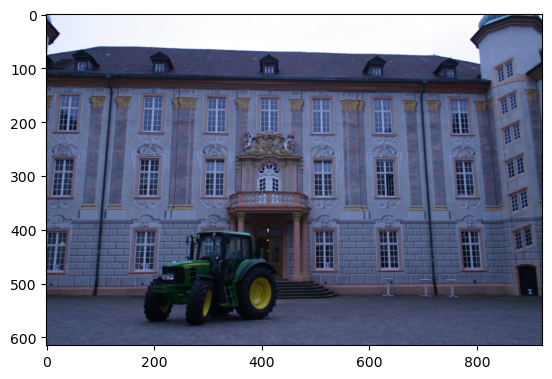

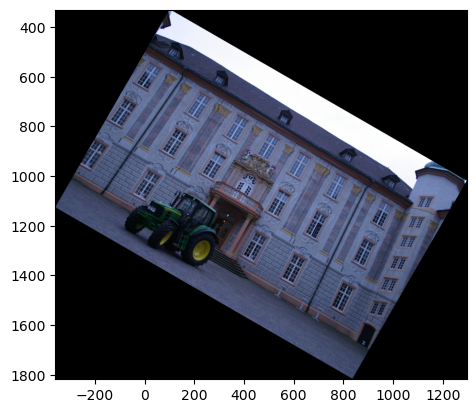

In [382]:
theta = np.pi/6
R = [[math.cos(theta), -math.sin(theta)],
    [math.sin(theta), math.cos(theta)]]
s = 1.5
t = [100,330]
H = [[s*R[0][0],  s*R[0][1],  t[0]], 
     [s*R[1][0],  s*R[1][1],  t[1]], 
     [0,  0,  1]]

img_path = "./Data/0005_s.png"
I = Image.open(img_path)
I_sim, axis,_ = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_sim.astype(np.uint8), axis=axis)

### **1.2 Affinities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces an affine transformation.  </span>

<span style='color:Green'> - Decompose the affinity in four transformations: two
rotations, a scale, and a translation (you may use function *numpy.linalg.svd* for that).  </span>

<span style='color:Green'> - Verify that the product of the four previous transformations
produces the same matrix H as above.  </span>

<span style='color:Green'> - verify that the proper sequence of the four previous
transformations over the image I produces the same transformed image as before.  </span>

The MSE error is = 7.190138459045681e-33


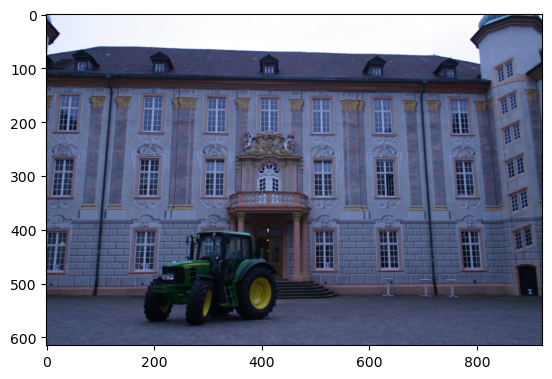

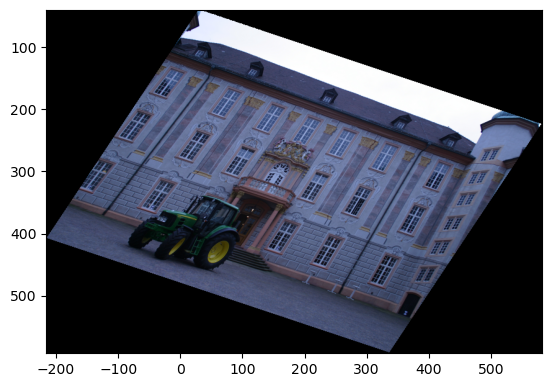

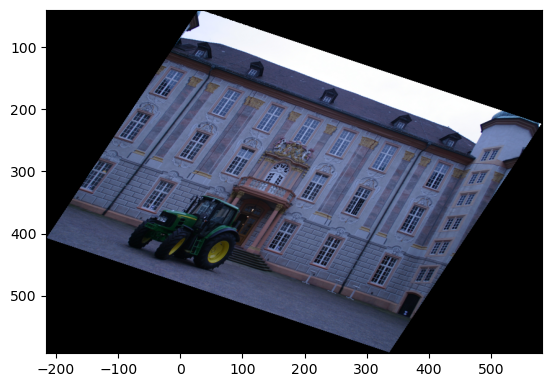

In [383]:
#Generate a matrix H which produces an affine transformation.  
A = [[0.6, -0.4],
     [0.2, 0.6]]
t = [30,40]
H = [[A[0][0],  A[0][1],  t[0]],
     [A[1][0],  A[1][1],  t[1]],
     [0,  0,  1]]

I_aff,axis,_ = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_aff.astype(np.uint8), axis=axis)

# Decompose the affinity in four transformations: two rotations, a scale, and a translation 
U, D, Vt = np.linalg.svd(A, full_matrices=False) #returns V already transposed and D are only the eigenvalues
D = np.diag(D)
R1 = np.matmul(U,Vt)
R2 = Vt

R_theta = np.array([[R1[0][0],  R1[0][1],  0],
                    [R1[1][0],  R1[1][1],  0],
                    [0, 0, 1]])
R_phi   = np.array([[R2[0][0],  R2[0][1],  0],
                    [R2[1][0],  R2[1][1],  0],
                    [0, 0, 1]])
D_scale = np.array([[D[0][0],  D[0][1],  0],
                    [D[1][0],  D[1][1],  0],
                    [0, 0, 1]])
T_transl= np.array([[1, 0,  t[0]],
                    [0, 1,  t[1]],
                    [0, 0, 1]])


# Verify that the product of the four previous transformations produces the same matrix H as above
H2 = np.matmul(T_transl,np.matmul(R_theta,np.matmul(R_phi.transpose(), np.matmul(D_scale,R_phi))))
MSE = ((H - H2)**2).mean(axis=None)
print(f'The MSE error is = {MSE}')

# Verify that the proper sequence of the four previous transformations over the image I produces the same transformed image as before. 
I_aff_svd, axis,_ = apply_H(np.array(I), H2)
plot_img(I_aff_svd.astype(np.uint8),axis=axis)

# #no se si vol dir la linia d'adalt o aplicar cada transformacio per separat ????????????????????????????
# I_aff_seq = apply_H(I, R_phi)
# I_aff_seq = apply_H(I_aff_seq, D_scale)
# I_aff_seq = apply_H(I_aff_seq, R_phi.transpose())
# I_aff_seq = apply_H(I_aff_seq, R_theta)
# I_aff_seq = apply_H(I_aff_seq, T_transl)
# plot_img(I_aff_seq.astype(np.uint8))

### **1.3 Projective transformations (Homographies)**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a projective transformation.  </span>

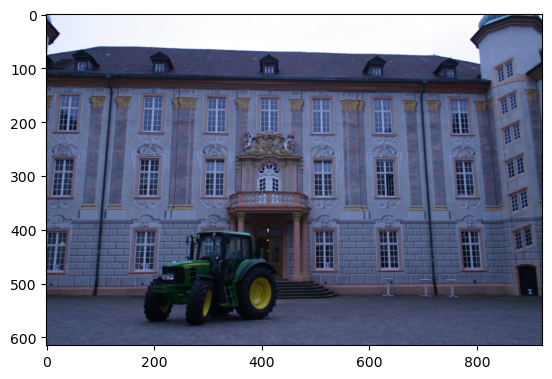

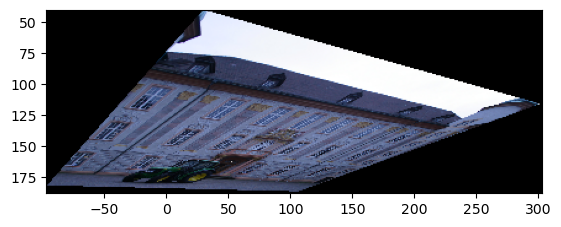

In [384]:
#H = ... # complete

A = [[0.6, -0.4],
     [0.2, 0.6]]
t = [30,40]
v = [0.001, 0.002]

H = [[A[0][0],  A[0][1],  t[0]],
     [A[1][0],  A[1][1],  t[1]],
     [v[0],     v[1],       1]]

I_proj,axis,_ = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_proj.astype(np.uint8),axis=axis)

## **2. Affine Rectification**

This step is needed in order to rectify an image in a stratified way, where we first perform affine rectification (current section) and then metric rectification (Section 3).

In [385]:
# load images and lines
img_path = "./Data/0000_s.png"
I = Image.open(img_path)

lines_path = "./Data/0000_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
i = 423 # line index
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i
i = 239
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 711
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 564
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

<span style='color:Green'> - Compute the lines l1, l2, l3, l4, that pass through the different pairs of points.  </span>

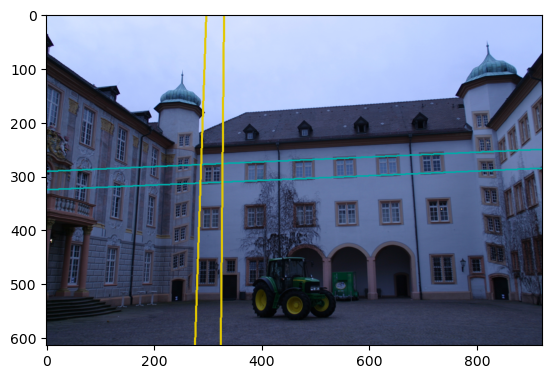

In [386]:
#The line that joins points p and p' is l = p x p'
l1 = np.cross(p1,p2)
l2 = np.cross(p3,p4)
l3 = np.cross(p5,p6)
l4 = np.cross(p7,p8)

# show the chosen lines in the image
I_wl = I.copy()
canv = ImageDraw.Draw(I_wl)
point_color = (0, 0, 255)
line_draw(l1, canv, I_wl.size,(0,171,169)) # horiz top
line_draw(l2, canv, I_wl.size,(0,171,169)) # horiz bottom
line_draw(l3, canv, I_wl.size,(227,200,0)) # vertical left
line_draw(l4, canv, I_wl.size,(227,200,0)) # vertical right

plot_img(I_wl)


<span style='color:Green'> - Compute the homography that affinely rectifies the image </span>

<span style='color:Green'> - Compute the transformed lines lar1, lar2, lar3, lar4 and
      show the transformed lines in the transformed image. </span>
      
<span style='color:Green'> - To evaluate the results, compute the angle between the different pair 
      of lines before and after the image transformation. </span>

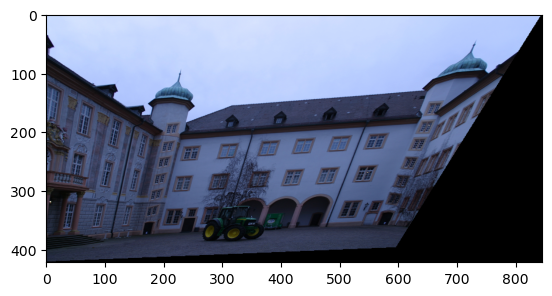

In [387]:
# Compute the homography that affinely rectifies the image 

# vanishing points (crossproduct of the parallel lines)
vp1 = np.cross(l1,l2)
vp2 = np.cross(l3,l4)

# get the line at infinity
l_inf = np.cross(vp1,vp2)
l_inf = np.divide(l_inf,l_inf[2]) 

# get the matrix Ha <-- p to perform the affine rectification
Ha_p = np.array([[1,0,0],
                 [0,1,0], 
                 [l_inf[0],l_inf[1],l_inf[2]]])

I_aff_rect, axis_aff, corners_aff_rect = apply_H(np.array(I), Ha_p)

# plot_img(I)
plot_img(I_aff_rect.astype(np.uint8), axis=axis_aff)


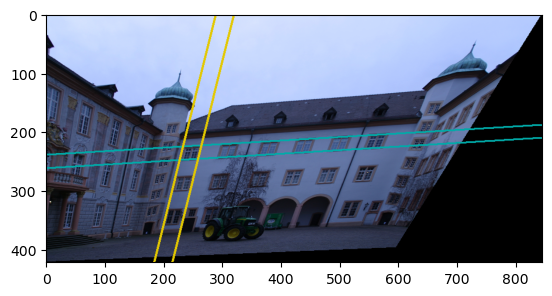

In [388]:
# Compute the transformed lines lar1, lar2, lar3, lar4
Ha_p_inv_t = np.transpose(LA.inv(Ha_p))
lar1 = np.matmul(Ha_p_inv_t, l1)
lar2 = np.matmul(Ha_p_inv_t, l2)
lar3 = np.matmul(Ha_p_inv_t, l3)
lar4 = np.matmul(Ha_p_inv_t, l4)

# show the transformed lines in the transformed image
I_aff_rect_wl = Image.fromarray(I_aff_rect.astype(np.uint8))
canv = ImageDraw.Draw(I_aff_rect_wl)
point_color = (0, 0, 255)
line_draw(lar1, canv, I_aff_rect_wl.size,(0,171,169)) # horiz top
line_draw(lar2, canv, I_aff_rect_wl.size,(0,171,169)) # horiz bottom
line_draw(lar3, canv, I_aff_rect_wl.size,(227,200,0)) # vertical left
line_draw(lar4, canv, I_aff_rect_wl.size,(227,200,0)) # vertical right


plot_img(I_aff_rect_wl, axis=axis_aff)


In [389]:
# Compute the angles between the transformed lines
angle_l1_l2 = angle(l1, l2)
angle_l3_l4 = angle(l3, l4)

angle_lar1_lar2 = angle(lar1, lar2)
angle_lar3_lar4 = angle(lar3, lar4)


print("Angles of parallel lines")
print(f'BEFORE the affine rectification: l1,l2 = {angle_l1_l2:.2f} and l3,l4 = {angle_l3_l4:.2f}')
print(f'AFTER the affine rectification:  l1,l2 = {angle_lar1_lar2:.2f} and l3,l4 = {angle_lar3_lar4:.2f}')


Angles of parallel lines
BEFORE the affine rectification: l1,l2 = 0.10 and l3,l4 = 1.34
AFTER the affine rectification:  l1,l2 = 0.00 and l3,l4 = 0.00


## **3. Metric Rectification**

### **3.1 Metric rectification after the affine rectification (stratified solution)**

<span style='color:Green'> - Write the code that performs the metric rectification (after the affine rectification). </span>


      


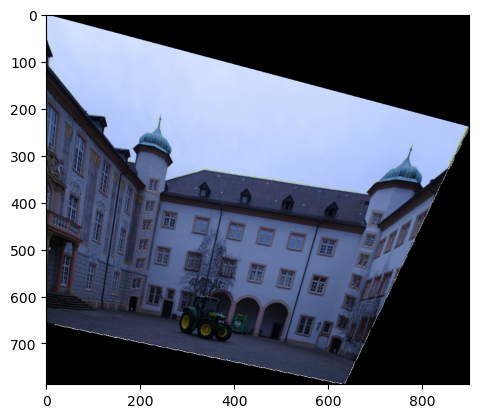

In [390]:
# We need two pairs of orhogonal lines -> l1,l3 and the diagonals of the windows l5,l6

# Get the diagonal lines between lar1 and lar2 and lar3 and lar4
lar5, lar6 = diagonal_lines(lar1, lar2, lar3, lar4)

# (l1*m1, l1*m2+l2*m1, l2*m2)*s = 0, with s=(s1,s2,s3) --> can be solved for S (therfore for K) finding the null space
eq1 = np.array([lar1[0]*lar3[0], lar1[0]*lar3[1]+lar1[1]*lar3[0], lar1[1]*lar3[1]])
eq2 = np.array([lar5[0]*lar6[0], lar5[0]*lar6[1]+lar5[1]*lar6[0], lar5[1]*lar6[1]])


# Compute the null space of the matrix of equations using numpy.linalg.null_space
s = null_space(np.array([eq1, eq2]), np.array([0,0]))

# The matrix S (2x2) = KK^t
S = [[s[0][0], s[1][0]], 
     [s[1][0], s[2][0]]]


#Knowing S, use the Cholesky decomposition of S to compute an upper triangular matrix K
K = LA.cholesky(S)

K_inv = LA.inv(K)
    
Hs_a = [[K_inv[0][0], K_inv[0][1], 0],
        [K_inv[1][0], K_inv[1][1], 0],
        [0, 0, 1]]

I_metric_rect, axis_metric, corners_metric= apply_H(I_aff_rect, Hs_a, corners_aff_rect) 

# plot_img(I)
plot_img(I_metric_rect.astype(np.uint8), axis=axis_metric)

As qualitative evaluation method you can display the images (before and after the metric rectification) with the chosen lines printed on it.

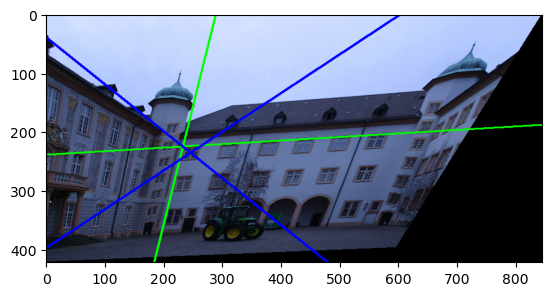

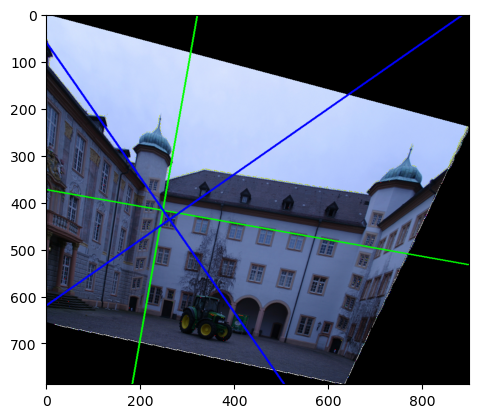

In [391]:
Ha_s_t = np.transpose(LA.inv(Hs_a))

# Compute the transformed lines
lmr1 = np.matmul(Ha_s_t, lar1)
lmr2 = np.matmul(Ha_s_t, lar2)
lmr3 = np.matmul(Ha_s_t, lar3)
lmr4 = np.matmul(Ha_s_t, lar4)
lmr5 = np.matmul(Ha_s_t, lar5)
lmr6 = np.matmul(Ha_s_t, lar6)


lmr1,lmr3,lmr5,lmr6 = lines_translation([lmr1,lmr3,lmr5,lmr6], corners_metric)

# show the transformed lines in the transformed image Before the metric rectification 
I_aff_rect_wl = Image.fromarray(I_aff_rect.astype(np.uint8))
canv = ImageDraw.Draw(I_aff_rect_wl)
line_draw(lar1, canv, I_aff_rect_wl.size,(0,255,0)) # horiz top
line_draw(lar3, canv, I_aff_rect_wl.size,(0,255,0)) # vertical left
line_draw(lar5, canv, I_aff_rect_wl.size,(0,0,255)) # diag
line_draw(lar6, canv, I_aff_rect_wl.size,(0,0,255)) # diag

plot_img(I_aff_rect_wl, axis=axis_aff)


# show the transformed lines in the transformed image After the metric rectification
I_metric_rect_wl = Image.fromarray(I_metric_rect.astype(np.uint8))
canv = ImageDraw.Draw(I_metric_rect_wl)
line_draw(lmr1, canv, I_metric_rect_wl.size,(0,255,0)) # horiz top
line_draw(lmr3, canv, I_metric_rect_wl.size,(0,255,0)) # vertical left
line_draw(lmr5, canv, I_metric_rect_wl.size,(0,0,255)) # diagonal
line_draw(lmr6, canv, I_metric_rect_wl.size,(0,0,255)) # diagonal

plot_img(I_metric_rect_wl, axis=axis_metric)


      
<span style='color:Green'> - Compute the angles between the pair of lines before and after rectification. Comment the result. </span>

In [392]:
angle_lar1_lar3 = angle(lar1, lar3)
angle_lar5_lar6 = angle(lar5, lar6)

angle_lmr1_lmr3 = angle(lmr1, lmr3)
angle_lmr5_lmr6 = angle(lmr5, lmr6)


print("Angles of orthogonal lines")
print(f'BEFORE the metric rectification: l1,l3 = {angle_lar1_lar3:.2f} and l5,l6 = {angle_lar5_lar6:.2f}')
print(f'AFTER the metric rectification:  l1,l3 = {angle_lmr1_lmr3:.2f} and l5,l6 = {angle_lmr5_lmr6:.2f}')

Angles of orthogonal lines
BEFORE the metric rectification: l1,l3 = 72.64 and l5,l6 = 72.01
AFTER the metric rectification:  l1,l3 = 90.00 and l5,l6 = 90.00


## **4. Affine and Metric Rectification of the left facade of image 0001**

<span style='color:Green'> - Write the code that rectifies the left facade of image 0001 with
      the stratified method.  </span>
      
Note: For a better visualization of the result crop the initial image so that only the left facade is visible.

<span style='color:Green'> - Show the (properly) transformed lines that are used in every step.  </span>
      
      

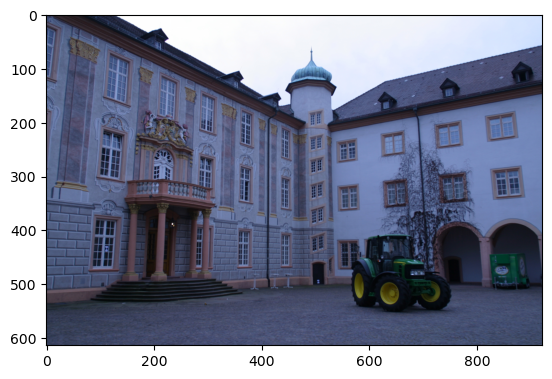

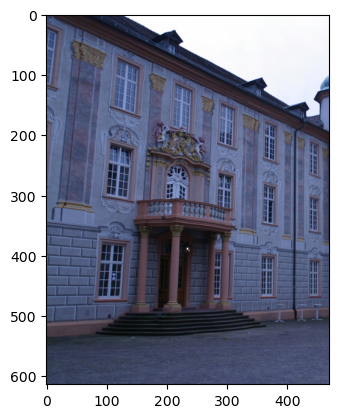

In [4]:
img_path = "./Data/0001_s.png"
I2 = Image.open(img_path)
h,w,c = np.array(I2).shape
# cropp image I to have only the pixels from 0 to 470 in the x axis and all the pixels in the y axis
I2_cropped = I2.crop((0, 0, 470, h))

plot_img(I2)
plot_img(I2_cropped)

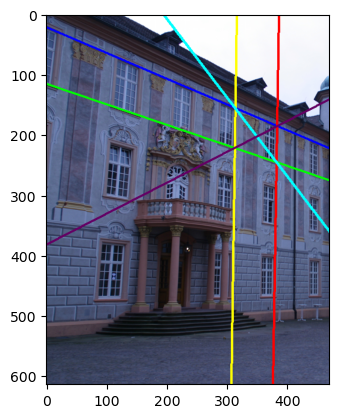

In [5]:
lines_path = "./Data/0001_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
i = 158 # line index
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i
i = 613
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 540
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 644
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

#The line that joins points p and p' is l = p x p'
l1 = np.cross(p1,p2)
l2 = np.cross(p3,p4)
l3 = np.cross(p5,p6)
l4 = np.cross(p7,p8)
# Compute the diagonal lines
l5, l6 = diagonal_lines(l1,l2,l3,l4)

# show the chosen lines in the image
I2_cropped_wl = I2_cropped.copy()
canv = ImageDraw.Draw(I2_cropped_wl)
line_draw(l1, canv, I2_cropped_wl.size,(0,255,0)) # horiz top
line_draw(l2, canv, I2_cropped_wl.size,(0,0,255)) # horiz bottom
line_draw(l3, canv, I2_cropped_wl.size,(255,0,0)) # vertical left
line_draw(l4, canv, I2_cropped_wl.size,(255,255,0)) # vertical right
line_draw(l5, canv, I2_cropped_wl.size,(0,255,255)) # diag
line_draw(l6, canv, I2_cropped_wl.size,(100,0,100)) # diag
# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I2_cropped_wl)

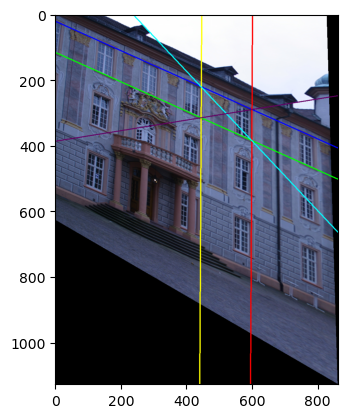

In [6]:
# Compute the homography that affinely rectifies the image 

# vanishing points (crossproduct of the parallel lines)
vp1 = np.cross(l1,l2)
vp2 = np.cross(l3,l4)

# get the line at infinity
l_inf = np.cross(vp1,vp2)
l_inf = np.divide(l_inf,l_inf[2])

# get the matrix Ha <-- p to perform the affine rectification
Ha_p = np.array([[1,0,0],
                 [0,1,0], 
                 [l_inf[0],l_inf[1],l_inf[2]]])

I_affine_rect, axis_affine, corners_affine = apply_H(np.array(I2_cropped), Ha_p)

# plot_img(I2_cropped)
# plot_img(I_affine_rect.astype(np.uint8), axis=axis)

# Compute the transformed lines lar1, lar2, lar3, lar4
Ha_p_inv_t = np.transpose(LA.inv(Ha_p))
lar1 = np.matmul(Ha_p_inv_t, l1)
lar2 = np.matmul(Ha_p_inv_t, l2)
lar3 = np.matmul(Ha_p_inv_t, l3)
lar4 = np.matmul(Ha_p_inv_t, l4)

# Compute the diagonal lines
lar5, lar6 = diagonal_lines(lar1,lar2,lar3,lar4)

# show the transformed lines in the transformed image
I_aff_rect_wl = Image.fromarray(I_affine_rect.astype(np.uint8))
canv = ImageDraw.Draw(I_aff_rect_wl)
line_draw(lar1, canv, I_aff_rect_wl.size,(0,255,0)) # horiz top
line_draw(lar2, canv, I_aff_rect_wl.size,(0,0,255)) # horiz bottom
line_draw(lar3, canv, I_aff_rect_wl.size,(255,0,0)) # vertical left
line_draw(lar4, canv, I_aff_rect_wl.size,(255,255,0)) # vertical right
line_draw(lar5, canv, I_aff_rect_wl.size,(0,255,255)) # diag
line_draw(lar6, canv, I_aff_rect_wl.size,(100,0,100)) # diag

plot_img(I_aff_rect_wl, axis = axis_affine)

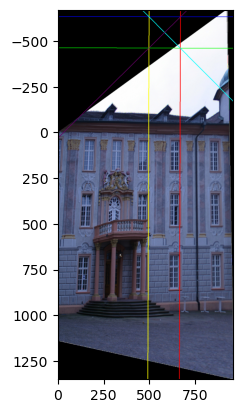

In [11]:
#METRIC RECTIFICATION
# (l1*m1, l1*m2+l2*m1, l2*m2)*s = 0, with s=(s1,s2,s3) --> can be solved for S (therfore for K) finding the null space
eq1 = np.array([lar1[0]*lar3[0], lar1[0]*lar3[1]+lar1[1]*lar3[0], lar1[1]*lar3[1]])
eq2 = np.array([lar5[0]*lar6[0], lar5[0]*lar6[1]+lar5[1]*lar6[0], lar5[1]*lar6[1]])


# Compute the null space of the matrix of equations using numpy.linalg.null_space
s = null_space(np.array([eq1, eq2]), np.array([0,0]))

# The matrix S (2x2) = KK^t
S = [[s[0][0], s[1][0]], 
     [s[1][0], s[2][0]]]


#Knowing S, use the Cholesky decomposition of S to compute an upper triangular matrix K
K = LA.cholesky(S)

K_inv = LA.inv(K)
    
Hs_a = [[K_inv[0][0], K_inv[0][1], 0],
        [K_inv[1][0], K_inv[1][1], 0],
        [0, 0, 1]]

I_metric_rect, axis_metric, corners_metric= apply_H(I_affine_rect, Hs_a, corners_affine) 


#lines rectification
Ha_s_t = np.transpose(LA.inv(Hs_a))


# Compute the transformed lines
lmr1 = np.matmul(Ha_s_t, lar1)
lmr2 = np.matmul(Ha_s_t, lar2)
lmr3 = np.matmul(Ha_s_t, lar3)
lmr4 = np.matmul(Ha_s_t, lar4)
lmr5 = np.matmul(Ha_s_t, lar5)
lmr6 = np.matmul(Ha_s_t, lar6)


lmr1, lmr2, lmr3, lmr4, lmr5,lmr6 = lines_translation([lmr1, lmr2, lmr3, lmr4, lmr5,lmr6], corners_metric)

# show all the transformed lines after the metric rectification
I_metric_rect_wl = Image.fromarray(I_metric_rect.astype(np.uint8))
canv = ImageDraw.Draw(I_metric_rect_wl)
line_draw(lmr1, canv, I_metric_rect_wl.size,(0,255,0)) # horiz top
line_draw(lmr2, canv, I_metric_rect_wl.size,(0,0,255)) # horiz bottom
line_draw(lmr3, canv, I_metric_rect_wl.size,(255,0,0)) # vertical left
line_draw(lmr4, canv, I_metric_rect_wl.size,(255,255,0)) # vertical right
line_draw(lmr5, canv, I_metric_rect_wl.size,(0,255,255)) # diag
line_draw(lmr6, canv, I_metric_rect_wl.size,(100,0,100)) # diag
plot_img(I_metric_rect_wl, axis=axis_metric)


In [10]:
angle_lar1_lar3 = angle(lar1, lar3)
angle_lar5_lar6 = angle(lar5, lar6)

angle_lmr1_lmr3 = angle(lmr1, lmr3)
angle_lmr5_lmr6 = angle(lmr5, lmr6)


print("Angles of orthogonal lines")
print(f'BEFORE the metric rectification: l1,l3 = {angle_lar1_lar3:.2f} and l5,l6 = {angle_lar5_lar6:.2f}')
print(f'AFTER the metric rectification:  l1,l3 = {angle_lmr1_lmr3:.2f} and l5,l6 = {angle_lmr5_lmr6:.2f}')

Angles of orthogonal lines
BEFORE the metric rectification: l1,l3 = 113.82 and l5,l6 = 124.14
AFTER the metric rectification:  l1,l3 = 90.00 and l5,l6 = 90.00


## **5. OPTIONAL: Metric Rectification in a single step**

<span style='color:Green'> - Write the code that performs metric rectification in a single step (algorithm pages 55-57, Hartley-Zisserman book). </span>

Note: Use 5 pairs of orthogonal lines. You may consider that windows are square.

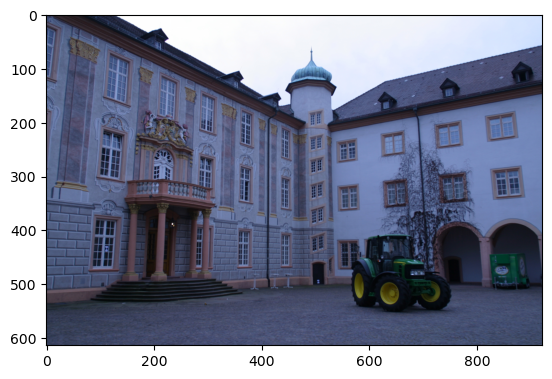

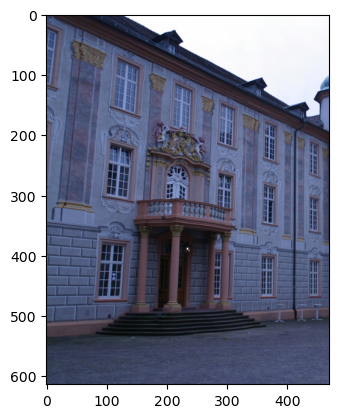

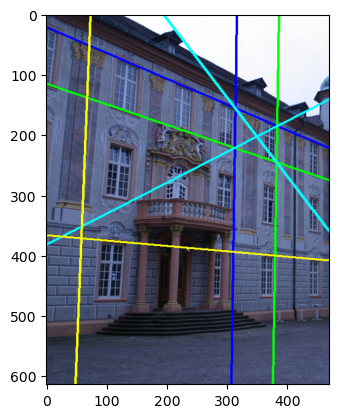

In [18]:
# FIND THE 5 Pairs of ORTHOGONAL LINES

img_path = "./Data/0001_s.png"
I2 = Image.open(img_path)
h,w,c = np.array(I2).shape
# cropp image I to have only the pixels from 0 to 470 in the x axis and all the pixels in the y axis
I2_cropped = I2.crop((0, 0, 470, h))

plot_img(I2)
plot_img(I2_cropped)

lines_path = "./Data/0001_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
i = 158 # line index
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i
i = 613
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 540
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 644
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

i = 187
p9 = [A[i, 0], A[i, 1], 1]
p10 = [A[i, 2], A[i, 3], 1]
i = 342
p11 = [A[i, 0], A[i, 1], 1]
p12 = [A[i, 2], A[i, 3], 1]

#The line that joins points p and p' is l = p x p'
l1 = np.cross(p1,p2)
l2 = np.cross(p3,p4)
l3 = np.cross(p5,p6)
l4 = np.cross(p7,p8)
# Compute the diagonal lines
l5, l6 = diagonal_lines(l1,l2,l3,l4)

l7 = np.cross(p9,p10)
l8 = np.cross(p11,p12)

# show the chosen lines in the image
I2_cropped_wl = I2_cropped.copy()
canv = ImageDraw.Draw(I2_cropped_wl)
line_draw(l1, canv, I2_cropped_wl.size,(0,255,0)) # horiz top
line_draw(l2, canv, I2_cropped_wl.size,(0,0,255)) # horiz bottom
line_draw(l3, canv, I2_cropped_wl.size,(0,255,0)) # vertical left
line_draw(l4, canv, I2_cropped_wl.size,(0,0,255)) # vertical right
line_draw(l5, canv, I2_cropped_wl.size,(0,255,255)) # diag
line_draw(l6, canv, I2_cropped_wl.size,(0,255,255)) # diag

line_draw(l7, canv, I2_cropped_wl.size,(255,255,0)) 
line_draw(l8, canv, I2_cropped_wl.size,(255,255,0)) 
# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I2_cropped_wl)

In [20]:
#  In this approach we start directly from the original perspective image of the plane (not affinely rectified)

# (l1m1, (l1m2 + l2m1)/2, l2m2, (l1m3 + l3m1)/2, (l2m3 + l3m2)/2, l3m3) c = 0

def get_equation(l,m):
        return np.array([l[0]*m[0], (l[0]*m[1] + l[1]*m[0])/2, l[1]*m[1], (l[0]*m[2] + l[2]*m[0])/2, (l[1]*m[2] + l[2]*m[1])/2, l[2]*m[2]])

eq1 = get_equation(l1,l3)
eq2 = get_equation(l2,l4)
eq3 = get_equation(l5,l6)
eq4 = get_equation(l7,l8)
eq5 = get_equation(l4,l8)

#get the conic matrix as a 6-vector
c = null_space(np.array([eq1, eq2, eq3, eq4, eq5]), np.array([0,0,0,0,0]))


C = [[c[0][0],   c[1][0]/2, c[3][0]/2], 
     [c[1][0]/2, c[2][0],   c[4][0]/2],
     [c[3][0]/2, c[4][0]/2, c[5][0]]]

U,D,V = LA.svd(C)

H = U

I_metric_rect, axis, corners_metric= apply_H(np.array(I2_cropped), H) 

plot_img(I_metric_rect.astype(np.uint8), axis=axis)




MemoryError: Unable to allocate 4.53 GiB for an array with shape (12547, 16165, 3) and data type float64

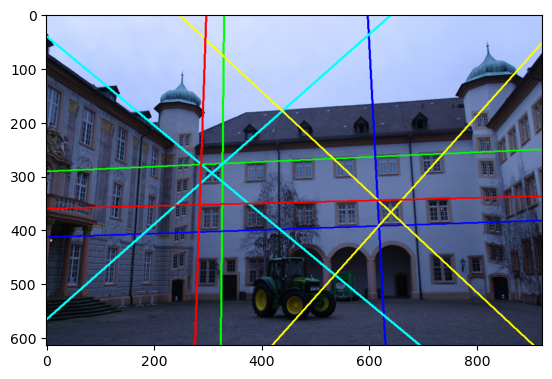

In [32]:
# FIND THE 5 Pairs of ORTHOGONAL LINES

img_path = "./Data/0000_s.png"
I2 = Image.open(img_path)
h,w,c = np.array(I2).shape


lines_path = "./Data/0000_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
i = 239 # line index
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i
i = 423
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 564
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 711
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

i = 366
p9 = [A[i, 0], A[i, 1], 1]
p10 = [A[i, 2], A[i, 3], 1]
i = 226
p11 = [A[i, 0], A[i, 1], 1]
p12 = [A[i, 2], A[i, 3], 1]
i = 575
p13 = [A[i, 0], A[i, 1], 1]
p14 = [A[i, 2], A[i, 3], 1]
i = 533
p15 = [A[i, 0], A[i, 1], 1]
p16 = [A[i, 2], A[i, 3], 1]

#The line that joins points p and p' is l = p x p'
l1 = np.cross(p1,p2)
l2 = np.cross(p3,p4)
l3 = np.cross(p5,p6)
l4 = np.cross(p7,p8)
l5 = np.cross(p9,p10)
l6 = np.cross(p11,p12)
l7 = np.cross(p13,p14)
l8 = np.cross(p15,p16)

l9,l10 = diagonal_lines(l1,l2,l3,l4)
l11,l12 = diagonal_lines(l5,l6,l7,l8)

# show the chosen lines in the image
I_wl = I2.copy()
canv = ImageDraw.Draw(I_wl)
line_draw(l2, canv, I_wl.size,(0,255,0)) 
line_draw(l3, canv, I_wl.size,(0,255,0)) 
line_draw(l5, canv, I_wl.size,(0,0,255))
line_draw(l8, canv, I_wl.size,(0,0,255)) 
line_draw(l9, canv, I_wl.size,(0,255,255)) 
line_draw(l10, canv, I_wl.size,(0,255,255)) 
line_draw(l11, canv, I_wl.size,(255,255,0)) 
line_draw(l12, canv, I_wl.size,(255,255,0)) 
line_draw(l4, canv, I_wl.size,(255,0,0)) 
line_draw(l6, canv, I_wl.size,(255,0,0)) 


# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I_wl)

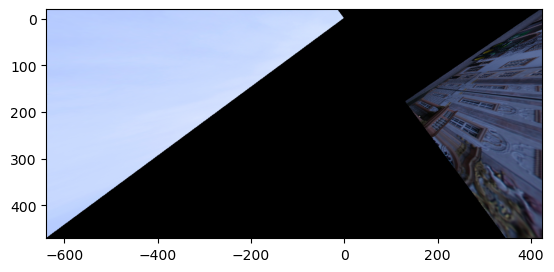

In [35]:
#  In this approach we start directly from the original perspective image of the plane (not affinely rectified)

# (l1m1, (l1m2 + l2m1)/2, l2m2, (l1m3 + l3m1)/2, (l2m3 + l3m2)/2, l3m3) c = 0

def get_equation(l,m):
        return np.array([l[0]*m[0], (l[0]*m[1] + l[1]*m[0])/2, l[1]*m[1], (l[0]*m[2] + l[2]*m[0])/2, (l[1]*m[2] + l[2]*m[1])/2, l[2]*m[2]])

eq1 = get_equation(l2,l3)
eq2 = get_equation(l5,l8)
eq3 = get_equation(l9,l10)
eq4 = get_equation(l11,l12)
eq5 = get_equation(l4,l6)

#get the conic matrix as a vector
c = null_space(np.array([eq1, eq2, eq3, eq4, eq5]), np.array([0,0,0,0,0]))

#get the conic matrix 
C = [[c[0][0],   c[1][0]/2, c[3][0]/2], 
     [c[1][0]/2, c[2][0],   c[4][0]/2],
     [c[3][0]/2, c[4][0]/2, c[5][0]]]

U,D,V = LA.svd(C)

H = U

I_metric_rect, axis, corners_metric= apply_H(np.array(I2), H) 

plot_img(I_metric_rect.astype(np.uint8), axis=axis)

